In [ ]:
import numpy as inumpy
import pandas as ipandas
import random
import matplotlib.pyplot as matplotPyplot
import seaborn as iseaborn
import sklearn.metrics as sklearnMetrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

In [ ]:
# This function lists out all permutations of ace values in the array sum_array
# For example, if you have 2 aces, as ace can represent as 1 or 11,
# then there will be 4 different kind of permutations:
#     [[1,1], [1,11], [11,1], [11,11]]
# These permutations lead to 3 unique sums when cal the total value: [2, 12, 22]
# In these 3, only 2 of them are <=21, so this function will only returned: [2, 12] as true value
def ace_value_array(saved_array):
    sum_array = inumpy.zeros((2**len(saved_array), len(saved_array)))
    # This loop gets all kind of combination of permutations
    for i in range(len(saved_array)):
        n = len(saved_array) - i
        half_len = int(2**n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)):
            sum_array[rep*2**n : rep*2**n+half_len, i] = 1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    # Only return values that are valid (<=21)
    # return list(set([int(s) for s in inumpy.sum(sum_array, axis=1) if s<=21]))
    return [int(s) for s in inumpy.sum(sum_array, axis=1)]

# Convert num_aces, an int to a list of lists
# For example, if there is two ace on hand
# here wll be num_aces=2, then the output should be [[1,11],[1,11]]
# These function to tell ace_value_array how much ace is now on hand
# and then cal the list of possibility of it
def ace_values(num_aces):
    saved_array = []
    for i in range(num_aces):
        saved_array.append([1,11])
    return ace_value_array(saved_array)

In [ ]:
# Pre-Function used for make a deck
def make_decks(num_decks, card_types):
    new_deck = []
    for i in range(num_decks):
        for j in range(4):
            new_deck.extend(card_types)
    random.shuffle(new_deck)
    return new_deck

# Defind total card value on hand
def total_card_value(hand):
    aces = 0
    total = 0

    for card in hand:
        if card != 'A':
            total += card
        else:
            aces += 1

    # Call function ace_values to produce list of possible values for aces in hand
    ace_value_list = ace_values(aces)
    # Double check to save only the value below or equal to 21 in the list
    final_totals = [i+total for i in ace_value_list if i+total<=21]

    if final_totals == []:
        return min(ace_value_list) + total
    else:
        return max(final_totals)

# A full function for play a game of blackjack after the cards are dealt
# play_game defines how the game will be play and decide the basic game rule
def play_game(dealer_hand, players_hand, blackjack, curr_player_results, dealer_cards, hit_stay, card_count, dealer_bust):
    action = 0
    # Dealer checks for 21
    # If Dealer have blackjack
    if set(dealer_hand) == blackjack:
        for player in range(players):
          # and player do not have blackjack, player lose
            if set(players_hand[player]) != blackjack:
                curr_player_results[0,player] = -1
            # Else, game draw
            else:
                curr_player_results[0,player] = 0
    else:
        for player in range(players):
            # Players check for 21
            # If player have blackjack, player win
            if set(players_hand[player]) == blackjack:
                curr_player_results[0,player] = 1
            else:
                # Hit randomly based on how many card on stack, then check for busts
                # If the hit decision value is >= 0.5 and hand value is not 21, hit for card
                if (hit_stay >= 0.5) and (total_card_value(players_hand[player]) != 21):
                    players_hand[player].append(dealer_cards.pop(0))
                    card_count[players_hand[player][-1]] += 1

                    action = 1
                    curr_total_val.append(total_card_value(players_hand[player]))
                    # If hand value > 21 after hit, bust and player lose
                    if total_card_value(players_hand[player]) > 21:
                        curr_player_results[0,player] = -1

    # Dealer hits based on the rules
    # Because computer count start from 0, needs to -1 to get the correct card count
    card_count[dealer_hand[-1]] += 1
    # Based on blackjack rule, if dealer's hand value < 17, dealer needs to hit
    while total_card_value(dealer_hand) < 17:
        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1

    # Compare dealer hand to players hand after all above action, but first check if dealer busted
    if total_card_value(dealer_hand) > 21:
        # There is an array called dealer_bust to count how many time dealer have bust for statistics usage afterward
        dealer_bust.append(1)
        # For future usage, current only one player is set as players = 1 although it cal for range(players)
        for player in range(players):
            # As dealer is busted, if player is not bust, then player wins
            if curr_player_results[0,player] != -1:
                curr_player_results[0,player] = 1
    else:
        # For the case if dealer is not bust to see player win, draw or lose
        dealer_bust.append(0)
        for player in range(players):
            if total_card_value(players_hand[player]) > total_card_value(dealer_hand):
                if total_card_value(players_hand[player]) <= 21:
                    curr_player_results[0,player] = 1
            elif total_card_value(players_hand[player]) == total_card_value(dealer_hand):
                curr_player_results[0,player] = 0
            else:
                curr_player_results[0,player] = -1
    # Return all the needed result from play_game function
    return curr_player_results, dealer_cards, action, card_count, dealer_bust

In [ ]:
# Configure how many cards, decks and player in the game
stacks = 40000
players = 1
num_decks = 1

# Because J, Q and K's value also count the value as 10, for easiler arrangement, from 10 - K, they will count as 4 same cards in one stack
card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_char = []
player_card_char = []
player_curr_total = []
player_curr_action = []
player_results = []
dealer_bust = []

# Pre-set this is the first game when it start
first_game = True
# Pre-set stack = 0 from previous game, define new stack is need for next game or not
prev_stack = 0
stack_list = []
new_stack = []
card_count_list = []
games_played_with_stack = []

for stack in range(stacks):
    games_played = 0

    # Make a list for keeping track of the card count for a stack
    card_count = {2: 0,
                  3: 0,
                  4: 0,
                  5: 0,
                  6: 0,
                  7: 0,
                  8: 0,
                  9: 0,
                  10: 0,
                  'A': 0}

    # Define what is blackjack, as A is 11, 10 is 10, the sum up is 21
    blackjack = set(['A',10])
    # Dealer suff the cards into decks
    dealer_cards = make_decks(num_decks, card_types)
    # Start the game with all empty hands

    while len(dealer_cards) > 20:

        curr_player_results = inumpy.zeros((1,players))

        dealer_hand = []
        players_hand = [[] for player in range(players)]
        curr_total_val = []
        # curr_count_action: future usage
        curr_count_action = []

        # Deal first card from the top of the card deck
        # For the blackjack game rules, players will take the card first and dealer will always be the last one to take
        for player, hand in enumerate(players_hand):
            players_hand[player].append(dealer_cards.pop(0))
            card_count[players_hand[player][-1]] += 1

        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1

        # Deal second card
        for player, hand in enumerate(players_hand):
            players_hand[player].append(dealer_cards.pop(0))
            card_count[players_hand[player][-1]] += 1

        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1

        # Record the player's live game total value after cards are dealt
        curr_total_val.append(total_card_value(players_hand[player]))

        # Decide to hit or stay just depends on the cards number in the stack
        # Player will decide to hit if the stack in this game is less then the half number of the stacks used in the whole training to see the result for learning
        # stack = card left record from prev_stack for current game
        if stack < stacks/2:
            hit_stay = 1
        else:
            hit_stay = 0

        curr_player_results, dealer_cards, action, card_count, dealer_bust = play_game(dealer_hand, players_hand,
                                                                          blackjack, curr_player_results,
                                                                          dealer_cards, hit_stay, card_count,
                                                                          dealer_bust)

        # Track the dealer and player's card characteristic
        dealer_card_char.append(dealer_hand[0])
        player_card_char.append(players_hand)
        #player_card_char.append(players_hand[[] for player in range(players)])
        player_results.append(list(curr_player_results[0]))
        player_curr_total.append(curr_total_val)
        player_curr_action.append(action)

        # Update card count list with most recent game's card count
        if stack != prev_stack:
            new_stack.append(1)
        else:
            new_stack.append(0)
            if first_game == True:
                first_game = False
            else:
                games_played += 1

        stack_list.append(stack)
        games_played_with_stack.append(games_played)
        card_count_list.append(card_count.copy())
        prev_stack = stack

# Build AI model based on two-dimensional, size-mutable data from the recorded card char
# class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=None)
model_bjai = ipandas.DataFrame()
model_bjai['dealer_card'] = dealer_card_char
model_bjai['player_total_initial'] = [total_card_value(i[0][0:2]) for i in player_card_char]
model_bjai['hit?'] = player_curr_action


# Define Ace for the AI
has_ace = []
for i in player_card_char:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_bjai['has_ace'] = has_ace

dealer_card_num = []
for i in model_bjai['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_bjai['dealer_card_num'] = dealer_card_num

model_bjai['Y'] = [i[0] for i in player_results]
lose = []
for i in model_bjai['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_bjai['lose'] = lose

correct = []
for i, val in enumerate(model_bjai['lose']):
    if val == 1:
        if player_curr_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_curr_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_bjai['correct_action'] = correct

In [ ]:
# Make a new version of model_bjai that has card counts
card_count_df = ipandas.concat([ipandas.DataFrame(new_stack, columns=['new_stack']),
                           ipandas.DataFrame(games_played_with_stack, columns=['games_played_with_stack']),
                           ipandas.DataFrame.from_dict(card_count_list),
                           ipandas.DataFrame(dealer_bust, columns=['dealer_bust'])], axis=1)
model_bjai = ipandas.concat([model_bjai, card_count_df], axis=1)

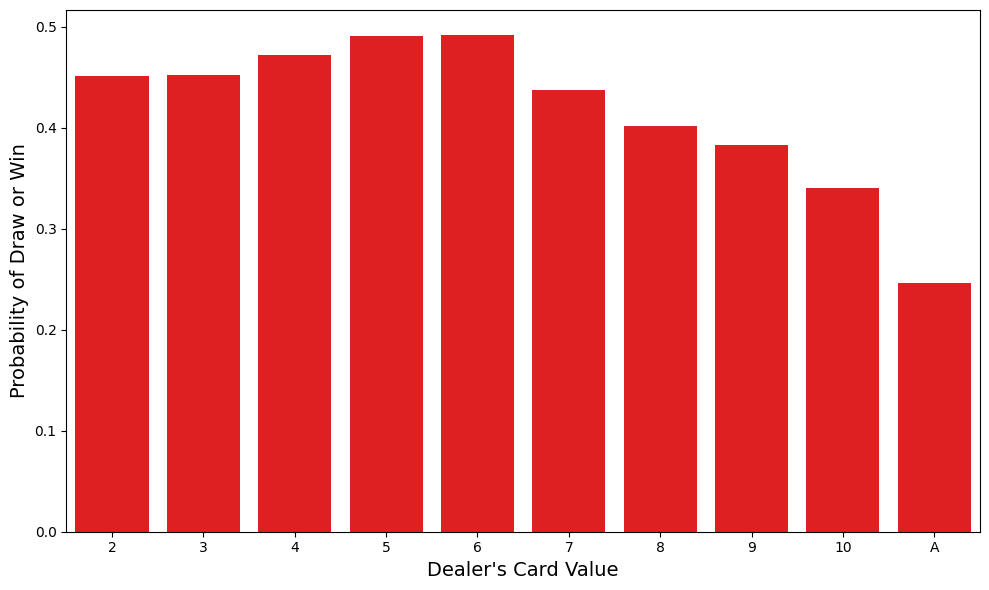

In [ ]:
# Bar Chart to see the probability of draw or win when dealer get what value of the cards
data = 1 - (model_bjai.groupby(by='dealer_card').sum()['lose'] /\
            model_bjai.groupby(by='dealer_card').count()['lose'])

#chart name = fig, axis = ax
fig, ax = matplotPyplot.subplots(figsize=(10,6))
ax = iseaborn.barplot(x=data.index,
                 y=data.values, color = 'r')

ax.set_xlabel("Dealer's Card Value",fontsize=14)
ax.set_ylabel("Probability of Draw or Win",fontsize=14)

matplotPyplot.tight_layout()

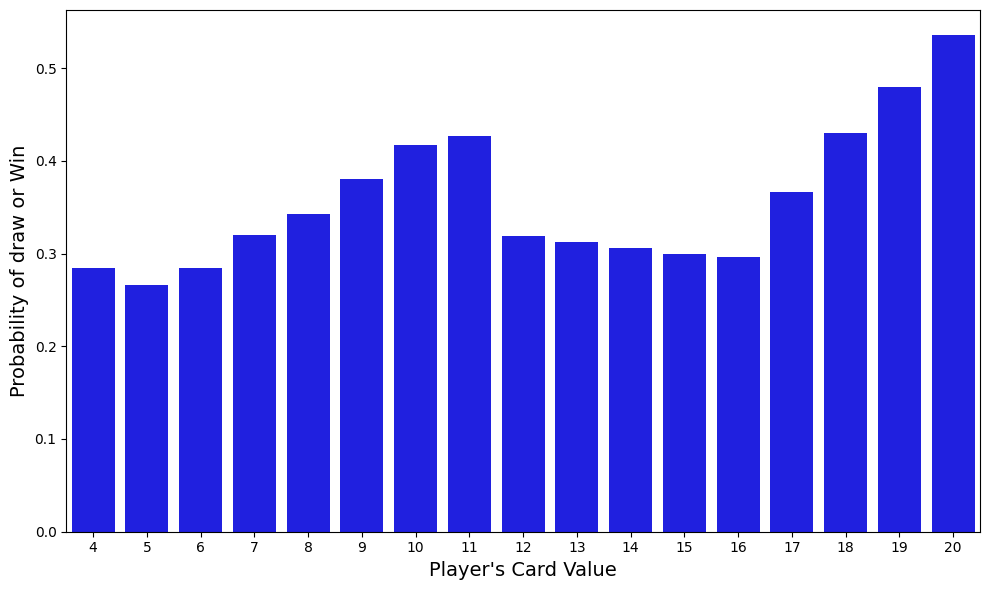

In [ ]:
# Bar Chart to see the probability of draw or win with player's specific hand value
data = 1 - (model_bjai.groupby(by='player_total_initial').sum(numeric_only=True)['lose'] /\
            model_bjai.groupby(by='player_total_initial').count()['lose'])

fig, ax = matplotPyplot.subplots(figsize=(10,6))
ax = iseaborn.barplot(x=data[:-1].index,
                 y=data[:-1].values, color = 'b')

ax.set_xlabel("Player's Card Value",fontsize=14)
ax.set_ylabel("Probability of draw or Win",fontsize=14)

matplotPyplot.tight_layout()

In [ ]:
# The probability of draw or win the game when having ace on hand
model_bjai.groupby(by='has_ace').sum(numeric_only=True)['lose'] / model_bjai.groupby(by='has_ace').count()['lose']

has_ace
0    0.643603
1    0.354002
Name: lose, dtype: float64

Text(170.72222222222223, 0.5, "Dealer's Card Value")

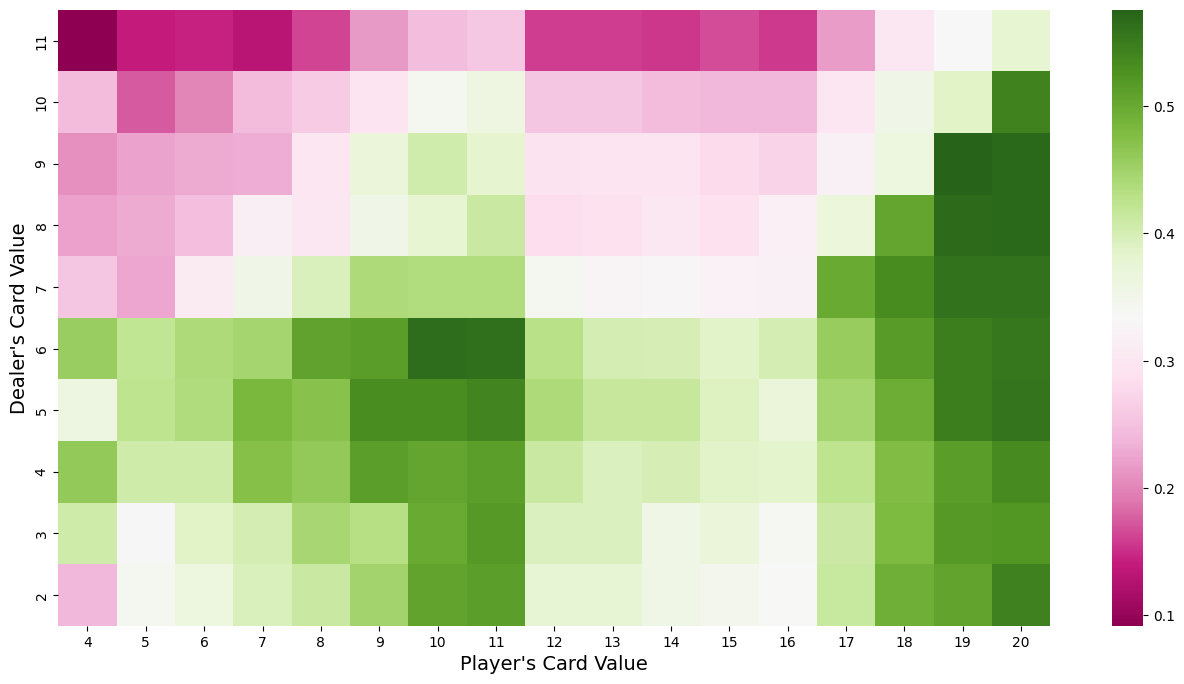

In [ ]:
# Figure of draw or win then specific player hand value meet with specific dealer on hand's card
player_pivot = model_bjai[model_bjai['player_total_initial'] != 21]

losses_pivot = ipandas.pivot_table(player_pivot, values='lose',
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = inumpy.sum)

games_pivot =  ipandas.pivot_table(player_pivot, values='lose',
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = 'count')

heatmap_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

fig, ax = matplotPyplot.subplots(figsize=(16,8))

# Create Seaborn Heatmap for analysis the win/draw propobility with player's card value agaist the dealer's
iseaborn.heatmap(heatmap_data, square=False, cmap="PiYG");

ax.set_xlabel("Player's Card Value",fontsize=14)
ax.set_ylabel("Dealer's Card Value",fontsize=14)



In [ ]:
# behaviour_list

In [ ]:
# With all the recorded data, now train a neural net to play blackjack
# Set up variables for neural net model
behaviour_list = [i for i in model_bjai.columns if i not in ['dealer_card',
                                                         'Y','lose',
                                                         'correct_action',
                                                         'dealer_bust',
                                                         'dealer_bust_pred',
                                                         'new_stack', 'games_played_with_stack',
                                                         2,3,4,5,6,7,8,9,10,'A',
                                                         'blackjack?'
                                                        ]]
train_X = inumpy.array(model_bjai[behaviour_list])
train_Y = inumpy.array(model_bjai['correct_action']).reshape(-1,1)

print(behaviour_list)
print('\n')

# Set up a neural net with 5 layers
model = Sequential()
# model.add(Dense(train_X.shape[1]+1))
model.add(Dense(16))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.fit(train_X, train_Y, epochs=200, batch_size=256, verbose=1)

pred_Y_train = model.predict(train_X)
actuals = train_Y[:,-1]

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']


Epoch 1/200
1008/1008 [==============================] - 5s 4ms/step - loss: 0.6573
Epoch 2/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6206
Epoch 3/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6163
Epoch 4/200
1008/1008 [==============================] - 3s 3ms/step - loss: 0.6146
Epoch 5/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6140
Epoch 6/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6139
Epoch 7/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6137
Epoch 8/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6138
Epoch 9/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6134
Epoch 10/200
1008/1008 [==============================] - 3s 3ms/step - loss: 0.6133
Epoch 11/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6132
Epoch 12/

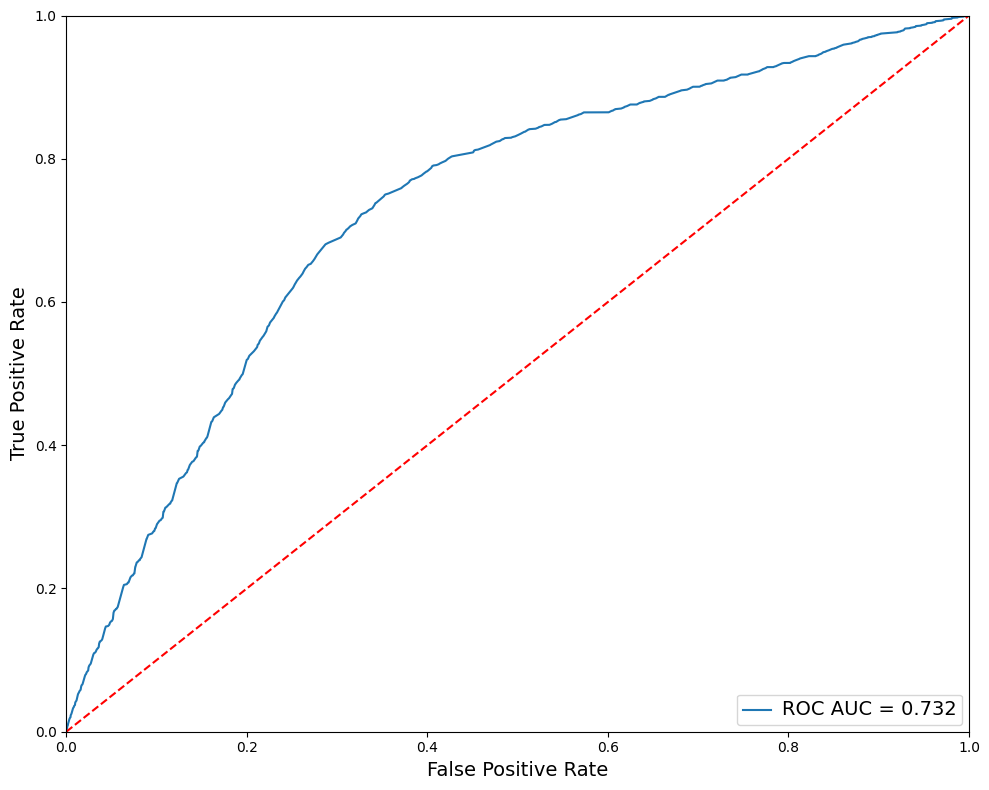

In [ ]:
# Plot ROC Curve for analysis

fpr, tpr, threshold = sklearnMetrics.roc_curve(actuals, pred_Y_train)
roc_auc = sklearnMetrics.auc(fpr, tpr)

fig, ax = matplotPyplot.subplots(figsize=(10,8))
matplotPyplot.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

matplotPyplot.legend(loc = 'lower right')
matplotPyplot.plot([0, 1], [0, 1],'r--')
matplotPyplot.xlim([0, 1])
matplotPyplot.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=14)
ax.set_ylabel("True Positive Rate",fontsize=14)
matplotPyplot.setp(ax.get_legend().get_texts(), fontsize=14)
matplotPyplot.tight_layout()
matplotPyplot.savefig(fname='roc_curve_blackjack', dpi=150)
matplotPyplot.show()

In [ ]:
# Define blackjack? is 21 by boolean
def func(x):
    if x == 21:
        return 1
    else:
        return 0

model_bjai['blackjack?'] = model_bjai['player_total_initial'].apply(func)

In [ ]:
# Train a neural net to predict blackjacks with all the collect data

predict_func = [2,3,4,5,6,7,8,9,10,'A','dealer_card_num']

# Set up variables for neural net
behaviour_list_bust = [i for i in predict_func if i not in ['dealer_bust']]
train_X_bust = inumpy.array(model_bjai[behaviour_list_bust])
train_Y_bust = inumpy.array(model_bjai['blackjack?']).reshape(-1,1)

print(behaviour_list_bust)
print('\n')

# Set up a neural net with 5 layers
model_predictbj = Sequential()
model_predictbj.add(Dense(train_X_bust.shape[1]))
model_predictbj.add(Dense(128))
model_predictbj.add(Dense(32, activation='relu'))
model_predictbj.add(Dense(8))
model_predictbj.add(Dense(1, activation='sigmoid'))
model_predictbj.compile(loss='binary_crossentropy', optimizer='sgd')
model_predictbj.fit(train_X_bust, train_Y_bust, epochs=200, batch_size=256, verbose=1)

pred_Y_train_bust = model_predictbj.predict(train_X_bust)
actuals = train_Y_bust[:,-1]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 'A', 'dealer_card_num']


Epoch 1/200
1008/1008 [==============================] - 3s 2ms/step - loss: 0.2061
Epoch 2/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1945
Epoch 3/200
1008/1008 [==============================] - 3s 3ms/step - loss: 0.1895
Epoch 4/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1858
Epoch 5/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1831
Epoch 6/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1809
Epoch 7/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1793
Epoch 8/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1782
Epoch 9/200
1008/1008 [==============================] - 3s 3ms/step - loss: 0.1772
Epoch 10/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1766
Epoch 11/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.1761
Epoch 12/200
1008/1

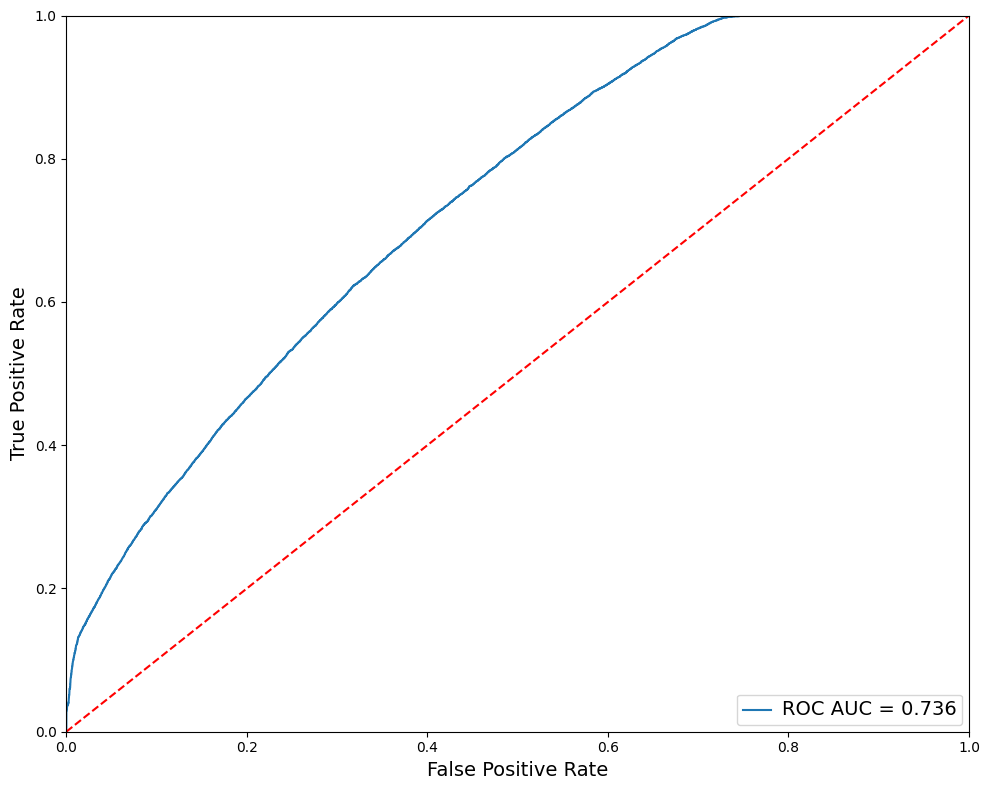

In [ ]:
# Plot ROC Curve for how well did the model train for predicting dealer bust

fpr, tpr, threshold = sklearnMetrics.roc_curve(actuals, pred_Y_train_bust)
roc_auc = sklearnMetrics.auc(fpr, tpr)

fig, ax = matplotPyplot.subplots(figsize=(10,8))
matplotPyplot.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

matplotPyplot.legend(loc = 'lower right')
matplotPyplot.plot([0, 1], [0, 1],'r--')
matplotPyplot.xlim([0, 1])
matplotPyplot.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=14)
ax.set_ylabel("True Positive Rate",fontsize=14)
matplotPyplot.setp(ax.get_legend().get_texts(), fontsize=14)
matplotPyplot.tight_layout()
matplotPyplot.savefig(fname='roc_curve_blackjack', dpi=150)
matplotPyplot.show()

In [ ]:
# Given the relevant inputs, the function below uses the neural net to make a prediction
# and then based on that prediction, decides whether to hit or stay

def model_decision(model, player_sum, has_ace, dealer_card_num):
    input_array = inumpy.array([player_sum, 0, has_ace, dealer_card_num]).reshape(1,-1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.52:
        return 1
    else:
        return 0

In [ ]:
def bust_Z_score(pred, pred_mean, pred_std):
    return (pred - pred_mean)/pred_std

pred_mean = model_predictbj.predict(train_X_bust).mean()
pred_std = model_predictbj.predict(train_X_bust).std()

8062/8062 [==============================] - 12s 1ms/step


In [ ]:
# Play blackjack but use the neural net to make hit/stay decision fo improvement
# And use a second neural net to decide how much to bet based on probability of dealer busting
# See if it can win the actual game by learning the experience itself without human's stratgery
game_rounds = 101
bankrolls = []
dumb_bankrolls = []

for night in range(game_rounds):

    dollars = 10000
    dumb_dollars = 10000
    bankroll = []
    dumb_bankroll = []
    stacks = 101
    players = 1
    num_decks = 1

    card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

    dealer_card_char = []
    player_card_char = []
    player_curr_total = []
    player_curr_action = []
    player_results = []

    first_game = True
    prev_stack = 0
    stack_list = []
    new_stack = []
    card_count_list = []
    games_played_with_stack = []

    for stack in range(stacks):
        games_played = 0

        if stack != prev_stack:
            temp_new_stack = 1
        else:
            temp_new_stack = 0

        # Make a dict for keeping track of the count for a stack
        card_count = {2: 0,
                      3: 0,
                      4: 0,
                      5: 0,
                      6: 0,
                      7: 0,
                      8: 0,
                      9: 0,
                      10: 0,
                      'A': 0}

        blackjack = set(['A',10])
        dealer_cards = make_decks(num_decks, card_types)
        while len(dealer_cards) > 20:
            multiplier = 1

            curr_player_results = inumpy.zeros((1,players))

            dealer_hand = []
            players_hand = [[] for player in range(players)]
            curr_total_val = []
            curr_count_action = []

            # Record card count
            cc_array_bust = ipandas.DataFrame.from_dict([card_count])

            # Deal FIRST card
            for player, hand in enumerate(players_hand):
                players_hand[player].append(dealer_cards.pop(0))
            dealer_hand.append(dealer_cards.pop(0))
            # Deal SECOND card
            for player, hand in enumerate(players_hand):
                players_hand[player].append(dealer_cards.pop(0))
            dealer_hand.append(dealer_cards.pop(0))

            # Record the player's live total after cards are dealt
            curr_total_val.append(total_card_value(players_hand[player]))
            action = 0

            # Dealer checks for 21
            if set(dealer_hand) == blackjack:
                for player in range(players):
                    if set(players_hand[player]) != blackjack:
                        curr_player_results[0,player] = -1
                    else:
                        curr_player_results[0,player] = 0
            else:
                for player in range(players):
                    # Players check for 21
                    if set(players_hand[player]) == blackjack:
                        curr_player_results[0,player] = 1
                        multiplier = 1.25
                    else:
                        # Neural net decides whether to hit or stay
                        if 'A' in players_hand[player][0:2]:
                            ace_in_hand = 1
                        else:
                            ace_in_hand = 0
                        if dealer_hand[0] == 'A':
                            dealer_face_up_card = 11
                        else:
                            dealer_face_up_card = dealer_hand[0]

                            while (model_decision(model, total_card_value(players_hand[player]), ace_in_hand, dealer_face_up_card) == 1) and (total_card_value(players_hand[player]) != 21):
                              players_hand[player].append(dealer_cards.pop(0))
                              action = 1
                              curr_total_val.append(total_card_value(players_hand[player]))
                              if total_card_value(players_hand[player]) > 21:
                                curr_player_results[0,player] = -1
                                break

            # Dealer hits based on the rules
            while total_card_value(dealer_hand) < 17:
                dealer_hand.append(dealer_cards.pop(0))
            # Compare dealer hand to players hand but first check if dealer busted
            if total_card_value(dealer_hand) > 21:
                for player in range(players):
                    if curr_player_results[0,player] != -1:
                        curr_player_results[0,player] = 1
            else:
                for player in range(players):
                    if total_card_value(players_hand[player]) > total_card_value(dealer_hand):
                        if total_card_value(players_hand[player]) <= 21:
                            curr_player_results[0,player] = 1
                    elif total_card_value(players_hand[player]) == total_card_value(dealer_hand):
                        curr_player_results[0,player] = 0
                    else:
                        curr_player_results[0,player] = -1

            input_array = inumpy.concatenate([cc_array_bust, inumpy.array(dealer_face_up_card).reshape(1,-1)], axis=1)
            # Predict blackjack bust propobility
            bust_pred = model_predictbj.predict(input_array)
            bust_Z = bust_Z_score(bust_pred, pred_mean, pred_std)
            #Bet on smart way with AI
            if bust_Z >= 0:
                bet = 100*(1 + bust_Z_score)
            else:
                bet = 100
            dollars+=curr_player_results[0,player]*bet*multiplier
            bankroll.append(dollars)

            #Bet on dumb way which will bet 100 what how
            dumb_bet = 100
            dumb_dollars+=curr_player_results[0,player]*dumb_bet
            dumb_bankroll.append(dumb_dollars)


            # Track features
            dealer_card_char.append(dealer_hand[0])
            player_card_char.append(players_hand)
            player_results.append(list(curr_player_results[0]))
            player_curr_total.append(curr_total_val)
            player_curr_action.append(action)

            # Update card count list with most recent game's card count
            if stack != prev_stack:
                new_stack.append(1)
            else:
                new_stack.append(0)
                if first_game == True:
                    first_game = False
                else:
                    games_played += 1

            stack_list.append(stack)
            games_played_with_stack.append(games_played)
            card_count_list.append(card_count.copy())
            prev_stack = stack

    model_bjai_smart = ipandas.DataFrame()
    model_bjai_smart['dealer_card'] = dealer_card_char
    model_bjai_smart['player_total_initial'] = [total_card_value(i[0][0:2]) for i in player_card_char]
    model_bjai_smart['hit?'] = player_curr_action

    has_ace = []
    for i in player_card_char:
        if ('A' in i[0][0:2]):
            has_ace.append(1)
        else:
            has_ace.append(0)
    model_bjai_smart['has_ace'] = has_ace

    dealer_card_num = []
    for i in model_bjai_smart['dealer_card']:
        if i=='A':
            dealer_card_num.append(11)
        else:
            dealer_card_num.append(i)
    model_bjai_smart['dealer_card_num'] = dealer_card_num

    model_bjai_smart['Y'] = [i[0] for i in player_results]
    lose = []
    for i in model_bjai_smart['Y']:
        if i == -1:
            lose.append(1)
        else:
            lose.append(0)
    model_bjai_smart['lose'] = lose

    bankrolls.append(bankroll)
    dumb_bankrolls.append(dumb_bankroll)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step


In [ ]:
bet_results = ipandas.DataFrame(bankrolls).T.fillna(method='ffill',axis=0)
dumb_bet_results = ipandas.DataFrame(dumb_bankrolls).T.fillna(method='ffill',axis=0)
bet_results.to_csv('bet.csv')
dumb_bet_results.to_csv('dumb_bet.csv')
smart_bets = ipandas.read_csv('bet.csv')
dumb_bets = ipandas.read_csv('dumb_bet.csv')

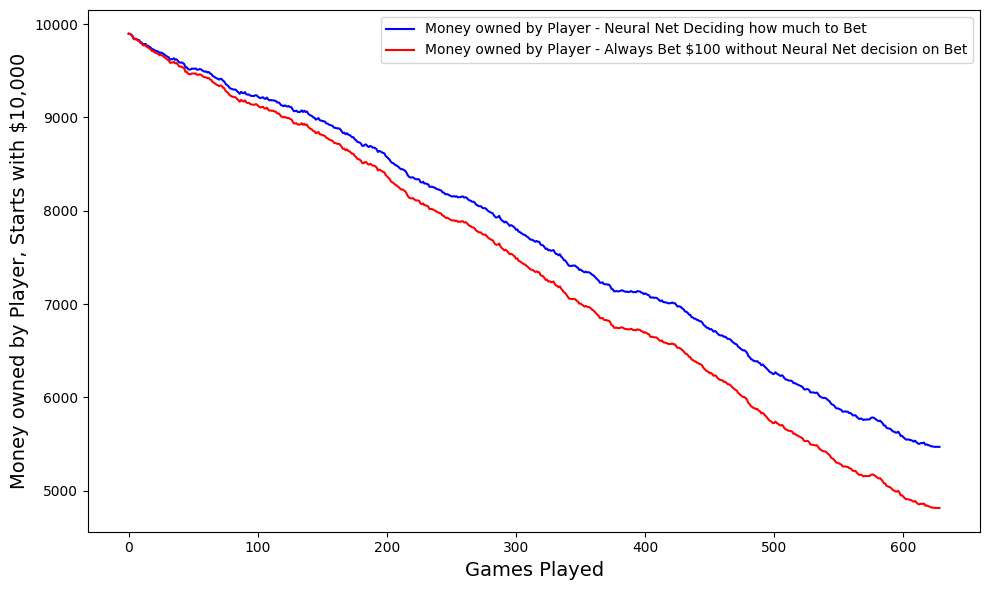

In [ ]:
# Line Chart to comapre and see how the player owning money situation becomes with or without the neural net decide how much he should bet, by the same game result base.
matplotPyplot.subplots(figsize=(10,6))
matplotPyplot.plot(smart_bets.mean(axis=1), label='Money owned by Player - Neural Net Deciding how much to Bet', color= 'b');
matplotPyplot.plot(dumb_bets.mean(axis=1), label='Money owned by Player - Always Bet $100 without Neural Net decision on Bet', color= 'r');
matplotPyplot.xlabel('Games Played', fontsize=14)
matplotPyplot.ylabel('Money owned by Player, Starts with $10,000', fontsize=14)
matplotPyplot.legend()
matplotPyplot.tight_layout()

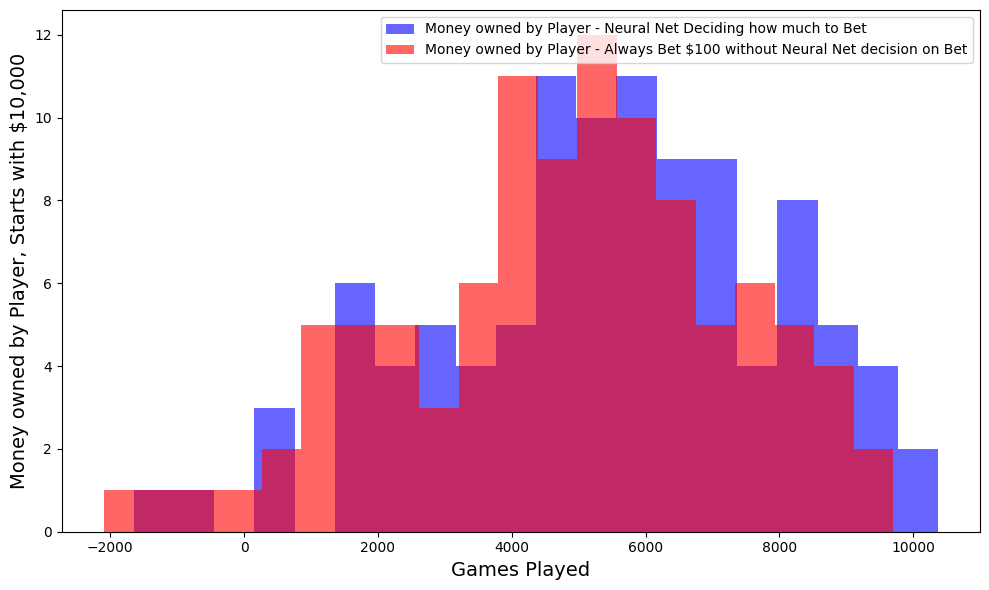

In [ ]:
# Histogram to comapre and see how the player owning money situation becomes with or without the neural net decide how much he should bet, by the same game result base.
matplotPyplot.subplots(figsize=(10,6))
matplotPyplot.hist(smart_bets.iloc[-1], label='Money owned by Player - Neural Net Deciding how much to Bet', bins=20, color= 'b', alpha=0.6);
matplotPyplot.hist(dumb_bets.iloc[-1], label='Money owned by Player - Always Bet $100 without Neural Net decision on Bet', bins=20, color= 'r', alpha=0.6);
matplotPyplot.xlabel('Games Played', fontsize=14)
matplotPyplot.ylabel('Money owned by Player, Starts with $10,000', fontsize=14)
matplotPyplot.legend()
matplotPyplot.tight_layout()

In [ ]:
# Count the percentage to show how much improve with the be with the netrual net's help
smart_bets.mean(axis=1).iloc[-1]/dumb_bets.mean(axis=1).iloc[-1] - 1

0.13609203548473814

In [ ]:
# The Actual Win, Draw and Lose percentage of the Netural Net played games
model_bjai_smart.groupby(by='Y').count()['lose']/model_bjai_smart.shape[0]

Y
-1.0    0.467532
 0.0    0.090909
 1.0    0.441558
Name: lose, dtype: float64

In [ ]:
print('Win or draw Rate:', 1-model_bjai_smart.sum(numeric_only=True)['lose']/model_bjai_smart.count()['lose'])

Win or draw Rate: 0.5324675324675325


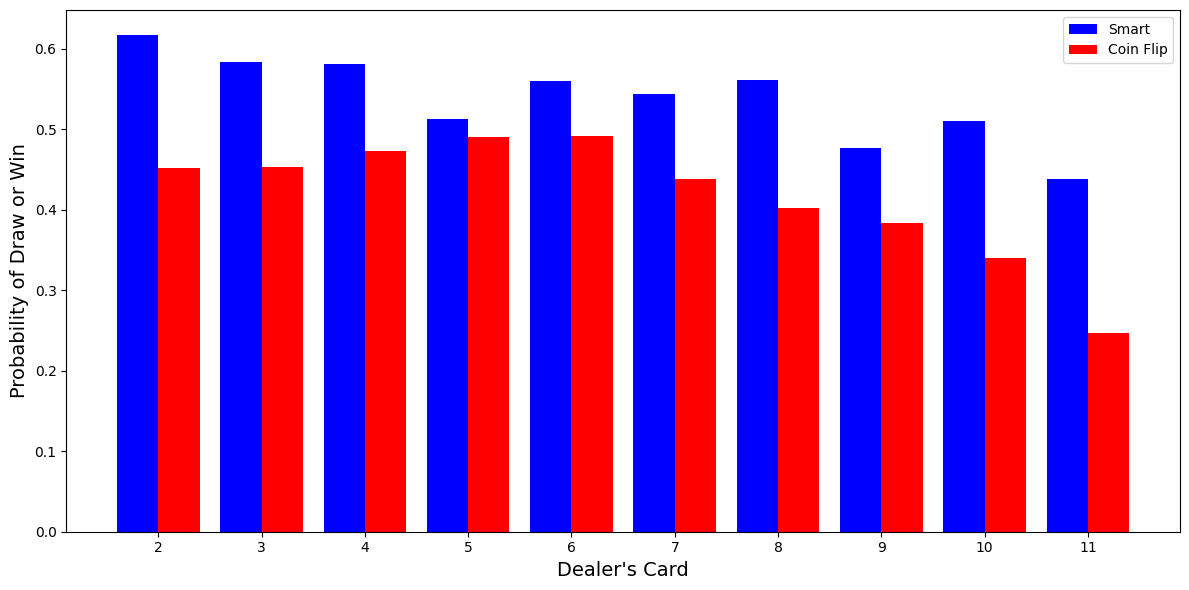

In [ ]:
data_smart = 1 - (model_bjai_smart.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_bjai_smart.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_bjai.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_bjai.groupby(by='dealer_card_num').count()['lose'])

data = ipandas.DataFrame()
data['smart'] = data_smart
data['random'] = data_random

fig, ax = matplotPyplot.subplots(figsize=(12,6))
ax.bar(x=data.index-0.2, height=data['smart'].values, color='blue', width=0.4, label='Smart')
ax.bar(x=data.index+0.2, height=data['random'].values, color='red', width=0.4, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of draw or Win",fontsize=16)
matplotPyplot.xticks(inumpy.arange(2, 12, 1.0))

matplotPyplot.legend()
matplotPyplot.tight_layout()
matplotPyplot.savefig(fname='dealer_card_probs_smart', dpi=150)